# Federated Learning Test

This notebook is a test of federated learning using the MNIST dataset. It distributes partial subsets of the MNIST data to each worker and tests the results of federation of the workers. It also skews the subsets to investigate the value of federation in cases where workers have substantially different samples.

## The Baseline

First, we load up the common elements to be used in the traditional and federated approaches. We start with the model.

In [1]:
# Define the model

import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

# # Optional model for fun

# import torch.nn.functional as F

# class LeNet(nn.Module):
#     def __init__(self):
#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=0) # value 0 was chosen arbitrarily to quiet a warning. Penny'll start a fire.

#     def name(self):
#         return 'LeNet'

In [2]:
# load the data

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# create standard datasets using all of the MNIST data

data_path = './MNIST-data/raw'
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

### Stacking a Deck

We need a way to "stack the deck" of examples that each worker sees. This method creates a dataset that is randomly sampled from a given dataset with the random sampling biased according to a dictionary of weights for each label.

In [3]:
from torch.utils.data import WeightedRandomSampler

def stacked_dset(dset, label_weights, N):
    """
    dset: dataset
    label_weights = {dog: 0.5, cat: 0.3, ...}
    N: size of stacked dset
    return: stacked WeightedRandomSampler
    """
    weights = []
    for data, label in dset:
        weights.append(label_weights[label])
    return WeightedRandomSampler(weights, N, replacement=False)

And this is where we get the dictionary of weights. For simplicity's sake, we just take a list of labels to be sampled "normally" and the rest are biased against. So, preserving 3s and skewing everything else by a factor of 0.9 shoud get a set of weights that results in a dataset that is slightly heavy on 3s compared to everything else. In an an extreme example, preserving only 3s, with a skew of 0, will produce weights that will yield a dataset of only 3s.

In [4]:
def skewed_weights(num_labels, labels_to_preserve, skew_bias):
    """
        num_labels: number of labels to return (use 10 for MNIST)
        labels_to_preserve: list of labels to preserve wih no skew 
        skew_bias: a float, 0 < bias < 1, to which non-selected labels will be biased down
        return: dictionary of each label and its bias
    """
    weights = {}
    for label in range(num_labels):
        if label in labels_to_preserve:
            weights[label] = 1
        else:
            weights[label] = skew_bias
    
    return weights

In [5]:
from torch.utils.data import DataLoader

batch_size = 64

# # create standard dataloaders using all of the MNIST data - this is for baseline purposes
train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

In [6]:
from collections import Counter

_, ys = list(zip(*test_dloader))
print("Test: ", Counter(int(y) for y in torch.cat(ys)).most_common())

_, ys = list(zip(*train_dloader))
print("Train:", Counter(int(y) for y in torch.cat(ys)).most_common())

Test:  [(1, 1135), (2, 1032), (7, 1028), (3, 1010), (9, 1009), (4, 982), (0, 980), (8, 974), (6, 958), (5, 892)]
Train: [(1, 6742), (7, 6265), (3, 6131), (2, 5958), (9, 5949), (0, 5923), (6, 5918), (8, 5851), (4, 5842), (5, 5421)]


These plots show quickly that the sets are distributed fairly similarly.

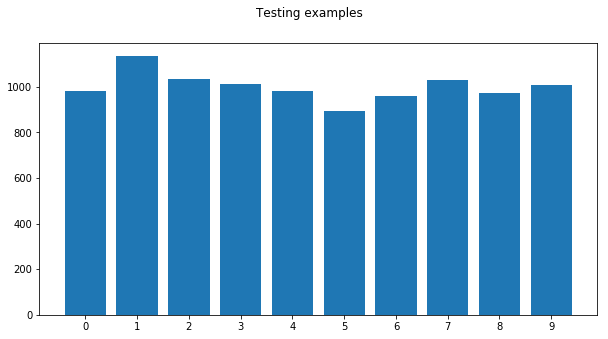

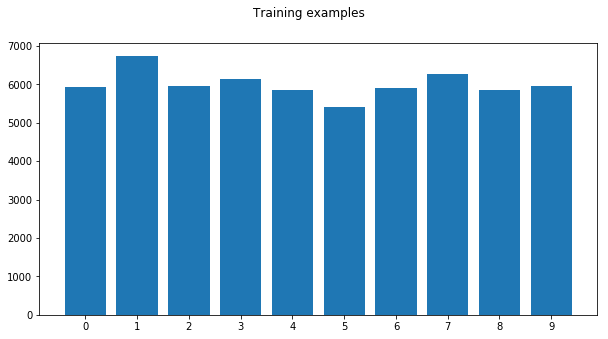

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Testing examples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
H = ax.hist(test_dloader.dataset.targets, bins=range(11), histtype='bar', align='left', rwidth=0.8)

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Training examples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
H = ax.hist(train_dloader.dataset.targets, bins=range(11), histtype='bar', align='left', rwidth=0.8)

Here we do the sampling to create our skewed datasets.

In [8]:
from tqdm import tqdm

# create stacked loaders for the workers

skew_bias = 0.5
loader_size = 8192
num_workers = 10

stacked_data_loaders = []

for label in tqdm(range(num_workers)):
    stacked_sampler = stacked_dset(train_dset, skewed_weights(10, [label], skew_bias), loader_size)
    stacked_data_loaders.append(DataLoader(train_dset, batch_size=batch_size, shuffle=False, sampler=stacked_sampler))

100%|██████████| 10/10 [01:20<00:00,  7.86s/it]


We should see the effect of the skew in a histogram of a skewed dataset.

In [9]:
_, ybatches = list(zip(*stacked_data_loaders[1]))
ys = torch.cat(ybatches)
ys = [int(y) for y in ys]
print(Counter(ys).most_common())

[(1, 1526), (3, 787), (9, 764), (2, 753), (0, 748), (8, 747), (7, 745), (6, 735), (4, 710), (5, 677)]


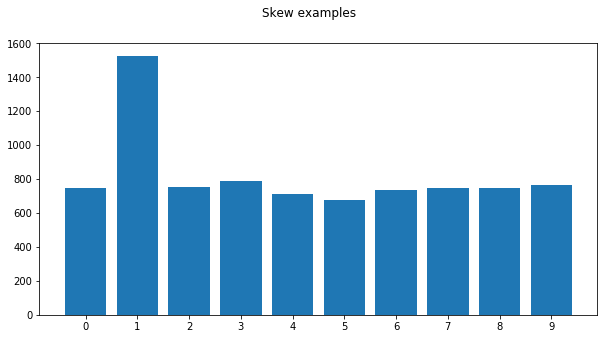

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Skew examples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
H = ax.hist(ys, bins=range(11), histtype='bar', align='left', rwidth=0.8)

In [11]:
import federated

learning_rate = 5e-3
num_epochs = 1
num_rounds = 8

skewed_train_dsets = stacked_data_loaders

manager = federated.FederatedManager(
    skewed_train_dsets,
    MLPNet,
    nn.CrossEntropyLoss(),
    learning_rate,
    test_dset,
    num_epochs
)

In [12]:
print("Training", num_rounds, "round(s) with", manager.n_workers, "worker(s) doing", num_epochs, "epoch(s) per round.\n" )

for i in tqdm(range(num_rounds)):
    print("Beginning round", i+1)
    manager.round()
    print("Finished round", i+1, "with global loss: %.5f" % manager.manager_loss_history[-1], "\n")

  0%|          | 0/8 [00:00<?, ?it/s]

Training 8 round(s) with 10 worker(s) doing 1 epoch(s) each

Beginning round 1
	Worker: 8912 	epoch: 1 	batch: 0 	local loss: 2.3095
	Worker: 8912 	epoch: 1 	batch: 32 	local loss: 2.2841
	Worker: 8912 	epoch: 1 	batch: 64 	local loss: 2.2795
	Worker: 8912 	epoch: 1 	batch: 96 	local loss: 2.2638
	Worker: 8912 	epoch: 1 	batch: 128 	local loss: 2.2410 

	Worker: 1184 	epoch: 1 	batch: 0 	local loss: 2.2935
	Worker: 1184 	epoch: 1 	batch: 32 	local loss: 2.2577
	Worker: 1184 	epoch: 1 	batch: 64 	local loss: 2.2520
	Worker: 1184 	epoch: 1 	batch: 96 	local loss: 2.2185
	Worker: 1184 	epoch: 1 	batch: 128 	local loss: 2.2297 

	Worker: 4712 	epoch: 1 	batch: 0 	local loss: 2.3093
	Worker: 4712 	epoch: 1 	batch: 32 	local loss: 2.2939
	Worker: 4712 	epoch: 1 	batch: 64 	local loss: 2.2749
	Worker: 4712 	epoch: 1 	batch: 96 	local loss: 2.2543
	Worker: 4712 	epoch: 1 	batch: 128 	local loss: 2.2410 

	Worker: 2976 	epoch: 1 	batch: 0 	local loss: 2.3067
	Worker: 2976 	epoch: 1 	batch: 32 	

 12%|█▎        | 1/8 [02:24<16:54, 144.90s/it]

Finished round 1 with global loss: 2.25973 

Beginning round 2
	Worker: 8912 	epoch: 1 	batch: 0 	local loss: 2.2671
	Worker: 8912 	epoch: 1 	batch: 32 	local loss: 2.2441
	Worker: 8912 	epoch: 1 	batch: 64 	local loss: 2.2186
	Worker: 8912 	epoch: 1 	batch: 96 	local loss: 2.1762
	Worker: 8912 	epoch: 1 	batch: 128 	local loss: 2.1650 

	Worker: 1184 	epoch: 1 	batch: 0 	local loss: 2.2537
	Worker: 1184 	epoch: 1 	batch: 32 	local loss: 2.2374
	Worker: 1184 	epoch: 1 	batch: 64 	local loss: 2.1848
	Worker: 1184 	epoch: 1 	batch: 96 	local loss: 2.1698
	Worker: 1184 	epoch: 1 	batch: 128 	local loss: 2.0834 

	Worker: 4712 	epoch: 1 	batch: 0 	local loss: 2.2574
	Worker: 4712 	epoch: 1 	batch: 32 	local loss: 2.2470
	Worker: 4712 	epoch: 1 	batch: 64 	local loss: 2.2251
	Worker: 4712 	epoch: 1 	batch: 96 	local loss: 2.1940
	Worker: 4712 	epoch: 1 	batch: 128 	local loss: 2.1700 

	Worker: 2976 	epoch: 1 	batch: 0 	local loss: 2.2568
	Worker: 2976 	epoch: 1 	batch: 32 	local loss: 2.24

 25%|██▌       | 2/8 [04:55<14:40, 146.71s/it]

Finished round 2 with global loss: 2.20645 

Beginning round 3
	Worker: 8912 	epoch: 1 	batch: 0 	local loss: 2.2079
	Worker: 8912 	epoch: 1 	batch: 32 	local loss: 2.1657
	Worker: 8912 	epoch: 1 	batch: 64 	local loss: 2.1696
	Worker: 8912 	epoch: 1 	batch: 96 	local loss: 2.1512
	Worker: 8912 	epoch: 1 	batch: 128 	local loss: 2.0815 

	Worker: 1184 	epoch: 1 	batch: 0 	local loss: 2.1809
	Worker: 1184 	epoch: 1 	batch: 32 	local loss: 2.1138
	Worker: 1184 	epoch: 1 	batch: 64 	local loss: 2.1822
	Worker: 1184 	epoch: 1 	batch: 96 	local loss: 2.0858
	Worker: 1184 	epoch: 1 	batch: 128 	local loss: 2.0707 

	Worker: 4712 	epoch: 1 	batch: 0 	local loss: 2.2259
	Worker: 4712 	epoch: 1 	batch: 32 	local loss: 2.2322
	Worker: 4712 	epoch: 1 	batch: 64 	local loss: 2.1747
	Worker: 4712 	epoch: 1 	batch: 96 	local loss: 2.1605
	Worker: 4712 	epoch: 1 	batch: 128 	local loss: 2.1379 

	Worker: 2976 	epoch: 1 	batch: 0 	local loss: 2.1804
	Worker: 2976 	epoch: 1 	batch: 32 	local loss: 2.14

 38%|███▊      | 3/8 [07:17<12:06, 145.28s/it]

Finished round 3 with global loss: 2.13383 

Beginning round 4
	Worker: 8912 	epoch: 1 	batch: 0 	local loss: 2.1080
	Worker: 8912 	epoch: 1 	batch: 32 	local loss: 2.1068
	Worker: 8912 	epoch: 1 	batch: 64 	local loss: 2.1099
	Worker: 8912 	epoch: 1 	batch: 96 	local loss: 2.0912
	Worker: 8912 	epoch: 1 	batch: 128 	local loss: 1.9708 

	Worker: 1184 	epoch: 1 	batch: 0 	local loss: 2.0930
	Worker: 1184 	epoch: 1 	batch: 32 	local loss: 2.1157
	Worker: 1184 	epoch: 1 	batch: 64 	local loss: 2.0923
	Worker: 1184 	epoch: 1 	batch: 96 	local loss: 1.9922
	Worker: 1184 	epoch: 1 	batch: 128 	local loss: 2.0232 

	Worker: 4712 	epoch: 1 	batch: 0 	local loss: 2.1279
	Worker: 4712 	epoch: 1 	batch: 32 	local loss: 2.1523
	Worker: 4712 	epoch: 1 	batch: 64 	local loss: 2.0540
	Worker: 4712 	epoch: 1 	batch: 96 	local loss: 2.0583
	Worker: 4712 	epoch: 1 	batch: 128 	local loss: 2.0424 

	Worker: 2976 	epoch: 1 	batch: 0 	local loss: 2.0961
	Worker: 2976 	epoch: 1 	batch: 32 	local loss: 2.06

 50%|█████     | 4/8 [09:43<09:42, 145.52s/it]

Finished round 4 with global loss: 2.02852 

Beginning round 5
	Worker: 8912 	epoch: 1 	batch: 0 	local loss: 1.9990
	Worker: 8912 	epoch: 1 	batch: 32 	local loss: 1.9553
	Worker: 8912 	epoch: 1 	batch: 64 	local loss: 1.9635
	Worker: 8912 	epoch: 1 	batch: 96 	local loss: 1.8862
	Worker: 8912 	epoch: 1 	batch: 128 	local loss: 2.0159 

	Worker: 1184 	epoch: 1 	batch: 0 	local loss: 2.0049
	Worker: 1184 	epoch: 1 	batch: 32 	local loss: 1.8966
	Worker: 1184 	epoch: 1 	batch: 64 	local loss: 2.0263
	Worker: 1184 	epoch: 1 	batch: 96 	local loss: 1.8344
	Worker: 1184 	epoch: 1 	batch: 128 	local loss: 1.8388 

	Worker: 4712 	epoch: 1 	batch: 0 	local loss: 2.1037
	Worker: 4712 	epoch: 1 	batch: 32 	local loss: 1.9452
	Worker: 4712 	epoch: 1 	batch: 64 	local loss: 1.9924
	Worker: 4712 	epoch: 1 	batch: 96 	local loss: 1.8774
	Worker: 4712 	epoch: 1 	batch: 128 	local loss: 1.8800 

	Worker: 2976 	epoch: 1 	batch: 0 	local loss: 2.0424
	Worker: 2976 	epoch: 1 	batch: 32 	local loss: 2.01

 62%|██████▎   | 5/8 [12:12<07:19, 146.33s/it]

Finished round 5 with global loss: 1.87907 

Beginning round 6
	Worker: 8912 	epoch: 1 	batch: 0 	local loss: 1.8694
	Worker: 8912 	epoch: 1 	batch: 32 	local loss: 1.6876
	Worker: 8912 	epoch: 1 	batch: 64 	local loss: 1.7634
	Worker: 8912 	epoch: 1 	batch: 96 	local loss: 1.6350
	Worker: 8912 	epoch: 1 	batch: 128 	local loss: 1.6437 

	Worker: 1184 	epoch: 1 	batch: 0 	local loss: 1.8512
	Worker: 1184 	epoch: 1 	batch: 32 	local loss: 1.7625
	Worker: 1184 	epoch: 1 	batch: 64 	local loss: 1.6659
	Worker: 1184 	epoch: 1 	batch: 96 	local loss: 1.6938
	Worker: 1184 	epoch: 1 	batch: 128 	local loss: 1.6157 

	Worker: 4712 	epoch: 1 	batch: 0 	local loss: 1.9320
	Worker: 4712 	epoch: 1 	batch: 32 	local loss: 1.8298
	Worker: 4712 	epoch: 1 	batch: 64 	local loss: 1.7597
	Worker: 4712 	epoch: 1 	batch: 96 	local loss: 1.8418
	Worker: 4712 	epoch: 1 	batch: 128 	local loss: 1.6526 

	Worker: 2976 	epoch: 1 	batch: 0 	local loss: 1.9562
	Worker: 2976 	epoch: 1 	batch: 32 	local loss: 1.80

 75%|███████▌  | 6/8 [14:32<04:48, 144.46s/it]

Finished round 6 with global loss: 1.68198 

Beginning round 7
	Worker: 8912 	epoch: 1 	batch: 0 	local loss: 1.7207
	Worker: 8912 	epoch: 1 	batch: 32 	local loss: 1.6035
	Worker: 8912 	epoch: 1 	batch: 64 	local loss: 1.5295
	Worker: 8912 	epoch: 1 	batch: 96 	local loss: 1.4978
	Worker: 8912 	epoch: 1 	batch: 128 	local loss: 1.5728 

	Worker: 1184 	epoch: 1 	batch: 0 	local loss: 1.7414
	Worker: 1184 	epoch: 1 	batch: 32 	local loss: 1.6118
	Worker: 1184 	epoch: 1 	batch: 64 	local loss: 1.5637
	Worker: 1184 	epoch: 1 	batch: 96 	local loss: 1.4854
	Worker: 1184 	epoch: 1 	batch: 128 	local loss: 1.3818 

	Worker: 4712 	epoch: 1 	batch: 0 	local loss: 1.7001
	Worker: 4712 	epoch: 1 	batch: 32 	local loss: 1.6000
	Worker: 4712 	epoch: 1 	batch: 64 	local loss: 1.7038
	Worker: 4712 	epoch: 1 	batch: 96 	local loss: 1.5315
	Worker: 4712 	epoch: 1 	batch: 128 	local loss: 1.3645 

	Worker: 2976 	epoch: 1 	batch: 0 	local loss: 1.7331
	Worker: 2976 	epoch: 1 	batch: 32 	local loss: 1.66

 88%|████████▊ | 7/8 [16:54<02:23, 143.89s/it]

Finished round 7 with global loss: 1.45819 

Beginning round 8
	Worker: 8912 	epoch: 1 	batch: 0 	local loss: 1.4788
	Worker: 8912 	epoch: 1 	batch: 32 	local loss: 1.4064
	Worker: 8912 	epoch: 1 	batch: 64 	local loss: 1.2291
	Worker: 8912 	epoch: 1 	batch: 96 	local loss: 1.2592
	Worker: 8912 	epoch: 1 	batch: 128 	local loss: 1.2219 

	Worker: 1184 	epoch: 1 	batch: 0 	local loss: 1.4856
	Worker: 1184 	epoch: 1 	batch: 32 	local loss: 1.3004
	Worker: 1184 	epoch: 1 	batch: 64 	local loss: 1.1839
	Worker: 1184 	epoch: 1 	batch: 96 	local loss: 1.2633
	Worker: 1184 	epoch: 1 	batch: 128 	local loss: 1.0235 

	Worker: 4712 	epoch: 1 	batch: 0 	local loss: 1.4558
	Worker: 4712 	epoch: 1 	batch: 32 	local loss: 1.4674
	Worker: 4712 	epoch: 1 	batch: 64 	local loss: 1.2438
	Worker: 4712 	epoch: 1 	batch: 96 	local loss: 1.3634
	Worker: 4712 	epoch: 1 	batch: 128 	local loss: 1.2204 

	Worker: 2976 	epoch: 1 	batch: 0 	local loss: 1.5902
	Worker: 2976 	epoch: 1 	batch: 32 	local loss: 1.42

100%|██████████| 8/8 [19:26<00:00, 146.18s/it]

Finished round 8 with global loss: 1.24550 



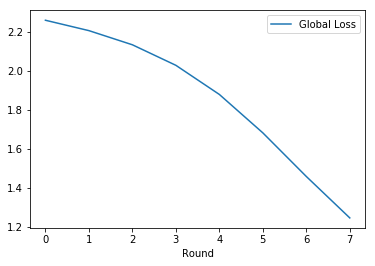

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2], label="Global Loss")
ax.set_xlabel("Round");
ax.legend();

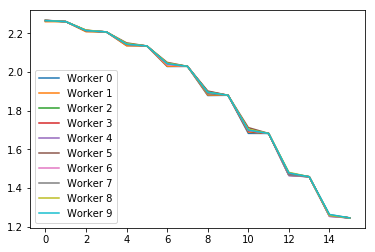

In [14]:
fig, ax = plt.subplots()

for i in range(len(manager.worker_loss_histories)):
    lbl = "Worker " + str(i)
    ax.plot(manager.worker_loss_histories[i], label=lbl)
    ax.legend();

Outline:
- Set up a model and data
- train the model N epochs without federation note baseline performance (and size of the data that would have to have been transferedd?) 
    - is this model trained on the full dataset? Or do we sample randomly across it to have the same number of examples?
- Federate without skew or mild skew, compare performance with baseline (and size of model compared to data)
- Federate with only a few numbers skewed (like, lacking only 7s or something) 
- Federate with heavy skew
- Federate with complete skew

Ideas:
- plot performance on a given numeral for the main model next to that of a worker skewed against that numeral. Let both run without federation or run a few epochs before federation. Show this as a baseline
- histogram of numerals? More for curiosity, but shows spread of data that we might want to reflect in the baseline training.
- why use ten workers? Why not fewer?

Questions:
- Why does the time spent by a worker on any given epoch all happen _before_ the batches start rolling in? What's happening there? Am I just spinning my wheels on something?
- Why does random selection of the skewed datasets take so long? Is it because they're without replacement?
- Why do all the workers and epochs always happen in order? Wouldn't my laptop parallelize them across cores? Is that too much to ask from an interpreter? Is the interpreter smarter than I am and actually is parallelizing them and the smartest way in to do them in order?